In [1]:
from comfy_script.runtime import *
load()
from comfy_script.runtime.nodes import *

ComfyScript: Using ComfyUI from http://127.0.0.1:8188/
Nodes: 1162
ComfyScript: ArtistStyler.artist: Too many enum values: 7743, truncating to 2000
ComfyScript: NounsStyler.nouns: Too many enum values: 90964, truncating to 2000
ComfyScript: VerbingStyler.verbing: Too many enum values: 3501, truncating to 2000
ComfyScript: ArtistStylerAdvanced.artist: Too many enum values: 7743, truncating to 2000
ComfyScript: NounsStylerAdvanced.nouns: Too many enum values: 90964, truncating to 2000
ComfyScript: VerbingStylerAdvanced.verbing: Too many enum values: 3501, truncating to 2000
ComfyScript: Load image with metadata [Crystools].image: Too many enum values: 34267, truncating to 2000


Queue remaining: 1
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remaining: 0
Queue remaining: 0
Queue remaining: 1
Queue remaining: 1
Queue remain

In [3]:
import time
import random
import jh_path
import os
import jh_prompts
import jh_TiROD
from collections import Counter


class_mapping = {
    # "road": "road",
    # "sidewalk": 1,
    "parking": "parked cars",
    # "rail track": 3,
    "person": "pedestrian",
    # "rider": 5,
    # "car": "car",
    "truck": "truck",
    "bus": "bus",
    # "on rails": 9,
    "motorcycle": "motorcycle",
    "bicycle": "bicycle",
    "caravan": "caravan",
    "trailer": "trailer",
    "building": "building",
    # "wall": "wall",
    "fence": "fence",
    "guard rail": "guard rail",
    "bridge": "bridge",
    "tunnel": "tunnel",
    "pole": "pole",
    # "pole group": 21,
    "traffic sign": "traffic sign",
    "traffic light": "traffic light",
    "plants": "plants",
    # "vegetation": 24,
    # "terrain": 25,
    # "sky": 26,
    # "ground": 27,
    # "dynamic": 28,
    # "static": 29,
}

# Dictionary input to prompt
def generate_sdxl_prompt(object_counts):
    if not object_counts:
        return ""

    # 이름 변경 매핑
    name_map = {
        "bottle": "plastic water bottle"
    }

    prompt_parts = []
    for name, count in object_counts.items():
        # 매핑된 이름 사용
        display_name = name_map.get(name, name)

        if count == 1:
            description = f"a single {display_name}"
        else:
            # 간단한 복수형 처리
            plural_name = display_name if display_name.endswith('s') else display_name + 's'
            description = f"{count} {plural_name}"
        prompt_parts.append(description)

    return ', '.join(prompt_parts)


# YOLO class names
yolo_names = [
    'slippers', 'stool', 'wire', 'carpet', 'sofa', 'socks', 'feces',
    'table', 'bed', 'closetool', 'book', 'cabinet', 'trashcan', 'curtain'
]

# 클래스 이름 매핑 (선택적 변경)
name_map = {
    'wire': 'electrical wire',
    'feces': 'feces on floor',
    'closetool': 'toilet',
    'stool': 'stool, chair'
}

def load_yolo_annotation(yolo_txt_path):
    """
    YOLO .txt 주석 파일에서 class_id만 추출해서 카운팅함
    """
    object_counts = Counter()

    if not os.path.isfile(yolo_txt_path):
        return {}

    with open(yolo_txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            try:
                class_id = int(parts[0])
                class_name = yolo_names[class_id]
                mapped_name = name_map.get(class_name, class_name)
                object_counts[mapped_name] += 1
            except (IndexError, ValueError):
                continue  # 잘못된 줄은 건너뜀

    return dict(object_counts)

def generate_prompt_YOLO(object_counts):
    if not object_counts:
        return ""

    prompt_parts = []
    for name, count in object_counts.items():
        if count == 1:
            description = f"a {name}"
        else:
            plural_name = name if name.endswith('s') else name + 's'
            description = f"{count} {plural_name}"
        prompt_parts.append(description)

    return ', '.join(prompt_parts)

In [ ]:
# Cityscapes Dataset Generation Code (img2img, with double controlnet)

img_list = jh_path.get_all_image_paths('input/Image_in')
print(len(img_list))


for img in img_list[0:1]:
    replaced_img = img.replace("Image_in", "Image_anno")
    replaced_img = replaced_img.replace("leftImg8bit", "gtFine_polygons")
    base, ext = os.path.splitext(replaced_img)
    json_path = base + '.json'

    img_path = img.replace("input/", "")
    # prompt from annotation
    obj_prompt = jh_path.label_from_json(json_path, class_mapping, 2000)
    # prompt concatenate
    pos_prompt_basic = '''high-quality photo, candid shot, high quality photorealism, road surface, urban roads, car, detailed, life-like texture, driver's view, naturally vibrant color, city landscape, detailed building and nature background, clear focus, diversity, car bonnet and hood ornament partially visible at bottom'''
    pos_prompt = pos_prompt_basic + obj_prompt
    neg_prompt = '(worst quality, low quality, illustration, drawing, 2d, painting, cartoons, sketch), low resolution, noisy, distortion, light flare, low-quality texture, over-saturation, jpeg artifact, over-polished, blur, bokeh, monotone'
    print(obj_prompt)
    print(img_path)
    img_filename = os.path.basename(img_path)

    with Workflow():
        model, clip, vae = CheckpointLoaderSimple('realvisxlV50_v50Bakedvae.safetensors')
        model = VectorscopeCC(model, True, 0, 0, 1, 0, 0, 0, 'Ones', '1 - Cos')
        model, clip = LoraLoader(model, clip, 'sd_xl_offset_example-lora_1.0.safetensors', 0.7, 0.8)
        positive_prompt_conditioning = CLIPTextEncode(pos_prompt, clip)
        negative_prompt_conditioning = CLIPTextEncode(neg_prompt, clip)
        control_net = ControlNetLoader('control-lora-canny-rank256.safetensors')
        image, _ = LoadImageFromPath(img_path)
        image2 = CannyEdgePreprocessor(image, 40, 100, 1024)
        apply_control_net_canny_positive, apply_control_net_canny_negative = ControlNetApplyAdvanced(positive_prompt_conditioning, negative_prompt_conditioning, control_net, image2, 0.6, 0, 0.8, None)
        control_net2 = ControlNetLoader('control-lora-depth-rank256.safetensors')
        image3 = DepthAnythingV2Preprocessor(image, 'depth_anything_v2_vits.pth', 1024)
        apply_control_net_depth_positive, apply_control_net_depth_negative = ControlNetApplyAdvanced(apply_control_net_canny_positive, apply_control_net_canny_negative, control_net2, image3, 0.8, 0, 0.9, vae)
        latent = VAEEncode(image, vae)
        latent = KSampler(model, random.randint(1,999999999999), 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.92)
        image4 = VAEDecode(latent, vae)
        save_filename = os.path.splitext(img_filename)[0]
        SaveImage(
                image4,
                "cityscapes4/" + save_filename,
                use_counter = True  )

    time.sleep(45)


In [ ]:
# Cityscapes Dataset Generation Code (img2img, with triple controlnet) - segmentation contronet added

img_list = jh_path.get_all_image_paths('input/Image_in')
print("Total number of Images: " + str(len(img_list)))

part_list = img_list[2000:]
cycle_len = len(part_list)

for i, img in enumerate(part_list):
    current_index = i + 1
    replaced_img = img.replace("Image_in", "Image_anno")
    replaced_img = replaced_img.replace("leftImg8bit", "gtFine_polygons")
    base, ext = os.path.splitext(replaced_img)
    json_path = base + '.json'

    seg_img = img.replace("Image_in", "Image_anno")
    seg_img = seg_img.replace("leftImg8bit", "gtFine_color")
    seg_img = seg_img.replace("input/", "")

    img_path = img.replace("input/", "")
    # prompt from annotation
    obj_prompt = jh_path.label_from_json(json_path, class_mapping, 2000)
    # prompt concatenate
    pos_prompt_basic = '''high-quality photo, road, candid shot, high quality photorealism, road surface, urban roads, car, detailed, life-like texture, driver's view, naturally vibrant color, city landscape, detailed building and nature background, clear focus, pedestrian, asphalt road, buildings, traffic signs, street tree, diversity, car bonnet and hood ornament partially visible at bottom'''
    pos_prompt = pos_prompt_basic + obj_prompt
    neg_prompt = '(worst quality, low quality, illustration, drawing, 2d, painting, cartoons, sketch), low resolution, noisy, distortion, light flare, low-quality texture, over-saturation, jpeg artifact, over-polished, blur, bokeh'
    print(obj_prompt)
    print(f"{current_index} is running among {cycle_len}")
    print(img_path)
    img_filename = os.path.basename(img_path)

    with Workflow():
        model, clip, vae = CheckpointLoaderSimple('realvisxlV50_v50Bakedvae.safetensors')
        model = VectorscopeCC(model, True, 0, 0, 1, 0, 0, 0, 'Ones', '1 - Cos')
        model, clip = LoraLoader(model, clip, 'sd_xl_offset_example-lora_1.0.safetensors', 0.7000000000000001, 0.8)
        positive_prompt_conditioning = CLIPTextEncode(pos_prompt, clip)
        negative_prompt_conditioning = CLIPTextEncode(neg_prompt, clip)
        control_net = ControlNetLoader('diffusion_pytorch_model_promax.safetensors')
        image, _ = LoadImage(seg_img)
        positive, negative = ControlNetApplyAdvanced(positive_prompt_conditioning, negative_prompt_conditioning, control_net, image, 0.4, 0, 0.8, None)
        control_net2 = ControlNetLoader('control-lora-canny-rank256.safetensors')
        image2, _ = LoadImage(img_path)
        image3 = CannyEdgePreprocessor(image2, 40, 100, 1024)
        apply_control_net_canny_positive, apply_control_net_canny_negative = ControlNetApplyAdvanced(positive, negative, control_net2, image3, 0.6, 0, 0.8, None)
        control_net3 = ControlNetLoader('control-lora-depth-rank256.safetensors')
        image4 = DepthAnythingV2Preprocessor(image2, 'depth_anything_v2_vits.pth', 1024)
        apply_control_net_depth_positive, apply_control_net_depth_negative = ControlNetApplyAdvanced(apply_control_net_canny_positive, apply_control_net_canny_negative, control_net3, image4, 0.7000000000000001, 0, 0.8, vae)
        latent = VAEEncode(image2, vae)
        latent = KSampler(model, random.randint(1,999999999999999), 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.92)
        image5 = VAEDecode(latent, vae)
        save_filename = os.path.splitext(img_filename)[0]
        SaveImage(
            image5,
            "cityscapes4/" + save_filename,
            use_counter = False  )

    time.sleep(50)


In [ ]:
# TiROD & CID-SIMS Dataset Generation Code (img2img, with double controlnet) - LLAVA Captioner implemented

img_list = jh_path.get_all_image_paths('input/TiROD/Domain1/High/images/train')
print("Total number of Images: " + str(len(img_list)))

# Partial Running
part_list = img_list[0:]
cycle_len = len(part_list)

# JSON load
replaced_img = img_list[0].replace("images", "annotations")
dir_path, file_name = os.path.split(replaced_img)
parent_path, train_folder = os.path.split(dir_path)
json_path = os.path.join(parent_path, "train.json")

for i, img in enumerate(part_list):
    current_index = i + 1
    print(img)
    # JSON prompt part
    filename_to_image_id, category_id_to_name, image_annotations = jh_TiROD.load_annotation_data(json_path)
    obj_dict = jh_TiROD.get_object_counts_for_image(os.path.basename(img), filename_to_image_id, category_id_to_name, image_annotations)
    obj_prompt = generate_sdxl_prompt(obj_dict)
    print(obj_prompt)
    
    img_path = img.replace("input/", "")
    
    # prompt concatenate
    pos_prompt_basic = ', high-quality photo, candid shot, high quality photorealism, detailed, life-like texture, low-angle indoor shot, only described objects'
    neg_prompt = '(worst quality, low quality, illustration, drawing, painting, cartoons, sketch), low resolution, noisy, distortion, UnrealisticDream, over-saturation, over-polished, blur, duplicated objects'
    
    print(f"{current_index} is running among {cycle_len}")
    # print(img_path)
    img_filename = os.path.basename(img_path)

    llava_prompt = '''Describe the locations of objects in the image using short phrases. Use expressions like "bottle on the right", "potted plant in the corner", "traffic cone near the box". Only output simple object-location phrases separated by commas.'''

    with Workflow():
        model, clip, vae = CheckpointLoaderSimple('realisticVisionV60B1_v51VAE.safetensors')
        model = VectorscopeCC(model, True, 0, 0, 1, 0, 0, 0, 'Ones', '1 - Cos')
        positive_prompt_basic_prompt = SeargePromptText(pos_prompt_basic)
        image, _ = LoadImage(img_path)

        # string = LlavaCaptioner(image, 'llava-v1.5-7b-Q4_K', 'llava-v1.5-7b-mmproj-Q4_0', llava_prompt, 100, 0.2)
        # string = ShowTextPysssss(string)

        # # # ACTIVATE to use LLAVA Captioner
        # string2 = TextConcatenate(r'\n', 'true', positive_prompt_basic_prompt, string, '', '')

        string2 = TextConcatenate(r'\n', 'true', obj_prompt, positive_prompt_basic_prompt, '', '')
        positive_prompt_conditioning = CLIPTextEncode(string2, clip)
        negative_prompt_conditioning = CLIPTextEncode(neg_prompt, clip)
        control_net = ControlNetLoader('control_v11p_sd15_canny.pth')
        upscale_model = UpscaleModelLoader('RealESRGAN_x2.pth')
        image2 = ImageUpscaleWithModel(upscale_model, image)
        image3 = CannyEdgePreprocessor(image2, 20, 80, 640)
        apply_control_net_canny_positive, apply_control_net_canny_negative = ControlNetApplyAdvanced(positive_prompt_conditioning, negative_prompt_conditioning, control_net, image3, 0.7, 0, 0.8, vae)
        control_net2 = ControlNetLoader('control_v11f1p_sd15_depth.pth')
        image4 = DepthAnythingV2Preprocessor(image2, 'depth_anything_v2_vitb.pth', 1024)
        apply_control_net_depth_positive, apply_control_net_depth_negative = ControlNetApplyAdvanced(apply_control_net_canny_positive, apply_control_net_canny_negative, control_net2, image4, 0.8, 0, 0.7, vae)
        latent = VAEEncode(image, vae)
        # RANDOM SEED
        # latent = KSampler(model, random.randint(1,999999999999999), 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.54)

        # UNIFORM SEED
        latent = KSampler(model, 555999869199, 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.55)
        image5 = VAEDecode(latent, vae)
        save_filename = os.path.splitext(img_filename)[0]
        SaveImage(
            image5,
            "TiROD_jsonprompt_uniform_5/" + save_filename,
            use_counter = False  )


    if i == 0:
        time.sleep(20)
    else:
        time.sleep(12)


In [ ]:
# TiROD & CID-SIMS Dataset Generation Code (img2img, with TRIPLE controlnet) - LLAVA Captioner implemented

img_list = jh_path.get_all_image_paths('input/TiROD/Domain1/High/images/train')
print("Total number of Images: " + str(len(img_list)))

# Partial Running
part_list = img_list[0:]
cycle_len = len(part_list)

# JSON load
replaced_img = img_list[0].replace("images", "annotations")
dir_path, file_name = os.path.split(replaced_img)
parent_path, train_folder = os.path.split(dir_path)
json_path = os.path.join(parent_path, "train.json")

for i, img in enumerate(part_list):
    current_index = i + 1
    print(img)
    # JSON prompt part
    filename_to_image_id, category_id_to_name, image_annotations = jh_TiROD.load_annotation_data(json_path)
    obj_dict = jh_TiROD.get_object_counts_for_image(os.path.basename(img), filename_to_image_id, category_id_to_name, image_annotations)
    obj_prompt = generate_sdxl_prompt(obj_dict)
    print(obj_prompt)
    
    img_path = img.replace("input/", "")
    
    # prompt concatenate
    pos_prompt_basic = ', high-quality photo, candid shot, high quality photorealism, detailed, life-like texture, low-angle indoor shot, only described objects'
    neg_prompt = '(worst quality, low quality, illustration, drawing, painting, cartoons, sketch), low resolution, noisy, distortion, UnrealisticDream, over-saturation, over-polished, blur, duplicated objects'
    
    print(f"{current_index} is running among {cycle_len}")
    # print(img_path)
    img_filename = os.path.basename(img_path)

    llava_prompt = '''Describe the locations of objects in the image using short phrases. Use expressions like "bottle on the right", "potted plant in the corner", "traffic cone near the box". Only output simple object-location phrases separated by commas.'''

    with Workflow():
        model, clip, vae = CheckpointLoaderSimple('realisticVisionV60B1_v51VAE.safetensors')
        model = VectorscopeCC(model, True, 0, 0, 1, 0, 0, 0, 'Ones', '1 - Cos')
        positive_prompt_basic_prompt = SeargePromptText(pos_prompt_basic)
        image, _ = LoadImage(img_path)

        # string = LlavaCaptioner(image, 'llava-v1.5-7b-Q4_K', 'llava-v1.5-7b-mmproj-Q4_0', llava_prompt, 100, 0.2)
        # string = ShowTextPysssss(string)

        # # # ACTIVATE to use LLAVA Captioner
        # string2 = TextConcatenate(r'\n', 'true', positive_prompt_basic_prompt, string, '', '')

        string2 = TextConcatenate(r'\n', 'true', obj_prompt, positive_prompt_basic_prompt, '', '')
        positive_prompt_conditioning = CLIPTextEncode(string2, clip)
        negative_prompt_conditioning = CLIPTextEncode(neg_prompt, clip)
        control_net = ControlNetLoader('controlnet_sd15_HED.safetensors')
        upscale_model = UpscaleModelLoader('RealESRGAN_x2.pth')
        image2 = ImageUpscaleWithModel(upscale_model, image)
        image3 = HEDPreprocessor(image2, 'enable', 640)
        
        apply_control_net_hed_positive, apply_control_net_hed_negative = ControlNetApplyAdvanced(positive_prompt_conditioning, negative_prompt_conditioning, control_net, image3, 0.7, 0, 0.8, vae)
        control_net2 = ControlNetLoader('control_v11p_sd15_canny.pth')
        image4 = CannyEdgePreprocessor(image2, 20, 80, 960)
        apply_control_net_canny_positive, apply_control_net_canny_negative = ControlNetApplyAdvanced(apply_control_net_hed_positive, apply_control_net_hed_negative, control_net2, image4, 0.8, 0, 0.7, vae)

        control_net3 = ControlNetLoader('control_v11f1p_sd15_depth.pth')
        image5 = DepthAnythingV2Preprocessor(image2, 'depth_anything_v2_vitb.pth', 1024)
        apply_control_net_depth_positive, apply_control_net_depth_negative = ControlNetApplyAdvanced(apply_control_net_canny_positive, apply_control_net_canny_negative, control_net3, image5, 0.8, 0, 0.7, vae)
        latent = VAEEncode(image, vae)
        # RANDOM SEED
        # latent = KSampler(model, random.randint(1,999999999999999), 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.54)

        # UNIFORM SEED
        latent = KSampler(model, 7894792311789, 40, 4, 'dpmpp_sde', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.50)
        image5 = VAEDecode(latent, vae)
        save_filename = os.path.splitext(img_filename)[0]
        SaveImage(
            image5,
            "TiROD_jsonprompt_uniform_9/" + save_filename,
            use_counter = False  )


    if i == 0:
        time.sleep(20)
    else:
        time.sleep(12)


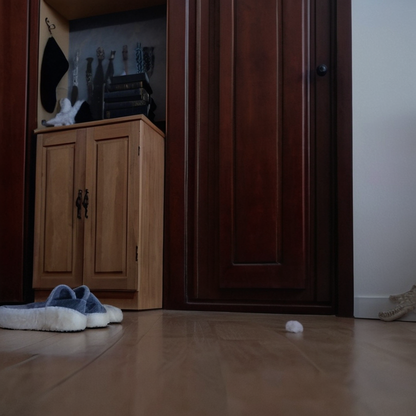

In [4]:
# ODSR-IHS Dataset Generation Code 

img_list = jh_path.get_all_image_paths('input/ODSR_og')
print("Total number of Images: " + str(len(img_list)))

# Partial Running
part_list = img_list[0:2160]
cycle_len = len(part_list)


for i, img in enumerate(part_list):
    current_index = i + 1
    print(img)
    # YOLO prompt part
    txt_path = os.path.splitext(img)[0] + ".txt"
    obj_dictionary = load_yolo_annotation(txt_path)
    obj_prompt = generate_prompt_YOLO(obj_dictionary)
    print(obj_prompt)
    
    img_path = img.replace("input/", "")
    
    # prompt concatenate
    pos_prompt_basic = 'high-quality photo, candid shot, high quality photorealism, detailed, life-like texture, low-angle indoor shot, '
    neg_prompt = '(worst quality, low quality, illustration, drawing, painting, cartoons, sketch), low resolution, noisy, distortion, UnrealisticDream, over-saturation, over-polished, blur, text, uniform color, monotone'
    pos_prompt_final = pos_prompt_basic + obj_prompt
    print(pos_prompt_final)
    print(f"{current_index} is running among {cycle_len}")
    # print(img_path)
    img_filename = os.path.basename(img_path)

    with Workflow():
        model, clip, vae = CheckpointLoaderSimple('realvisxlV50_v50Bakedvae.safetensors')
        model = VectorscopeCC(model, True, 0, 0, 1, 0, 0, 0, 'Ones', '1 - Cos')
        positive_prompt_basic_prompt = SeargePromptText(pos_prompt_basic)
        image, _ = LoadImage(img_path)

        # string = LlavaCaptioner(image, 'llava-v1.5-7b-Q4_K', 'llava-v1.5-7b-mmproj-Q4_0', llava_prompt, 100, 0.2)
        # string = ShowTextPysssss(string)

        # # # ACTIVATE to use LLAVA Captioner
        # string2 = TextConcatenate(r'\n', 'true', positive_prompt_basic_prompt, string, '', '')

        string2 = TextConcatenate(r'\n', 'true', obj_prompt, positive_prompt_basic_prompt, '', '')
        positive_prompt_conditioning = CLIPTextEncode(string2, clip)
        negative_prompt_conditioning = CLIPTextEncode(neg_prompt, clip)

        control_net = ControlNetLoader('control-lora-canny-rank256.safetensors')
        image2 = CannyEdgePreprocessor(image, 90, 160, 512)
        apply_control_net_canny_positive, apply_control_net_canny_negative = ControlNetApplyAdvanced(positive_prompt_conditioning, negative_prompt_conditioning, control_net, image2, 0.8, 0, 0.8, vae)
        control_net2 = ControlNetLoader('control-lora-depth-rank256.safetensors')
        upscale_model = UpscaleModelLoader('RealESRGAN_x2.pth')
        image3 = ImageUpscaleWithModel(upscale_model, image)
        image4 = DepthAnythingV2Preprocessor(image3, 'depth_anything_v2_vitb.pth', 1024)
        apply_control_net_depth_positive, apply_control_net_depth_negative = ControlNetApplyAdvanced(apply_control_net_canny_positive, apply_control_net_canny_negative, control_net2, image4, 0.9, 0, 0.8, vae)
        latent = VAEEncode(image3, vae)
        # RANDOM SEED
        # latent = KSampler(model, random.randint(1,999999999999999), 40, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.9)5080 ROP

        # UNIFORM SEED
        latent = KSampler(model, random.randint(1,999999999999999), 50, 5, 'dpmpp_2m', 'karras', apply_control_net_depth_positive, apply_control_net_depth_negative, latent, 0.95)
        image5 = VAEDecode(latent, vae)
        image6 = ImageResize(image5, 'rescale', 'true', 'lanczos', 0.5, 416, 416)
        save_filename = os.path.splitext(img_filename)[0]
        SaveImage(
            image6,
            "ODSR_v12/" + save_filename,
            use_counter = False  )


    if i == 0:
        time.sleep(25)
    else:
        time.sleep(20)